In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


- To forecast the consumption for each quarter of an hour over the next 24 hours (96 quarters).
- To forecast the consumption for each hour over the next four days (96 hours).
- To forecast the consumption for each day over the coming month (30 days).


# Historical Consumption
A selected time series of consumption data for over 200 buildings.

- obs_id - An arbitrary ID for the observationaa
- SiteId - An arbitrary ID number for the building, matches across datasets
- ForecastId - An ID for a timeseries that is part of a forecast (can be matched with the submission file)
- Timestamp - The time of the measurement
- Value - A measure of consumption for that building

# Building Metadata
Additional information about the included buildings.

- SiteId - An arbitrary ID number for the building, matches across datasets
- Surface - The surface area of the building
- BaseTemperature - The base temperature for the building
- [DAY_OF_WEEK]IsDayOff - True if DAY_OF_WEEK is not a work day

# Historical Weather Data
This dataset contains temperature data from several stations near each site. For each site several temperature measurements were retrieved from stations in a radius of 30 km if available.

Note: Not all sites will have available weather data.

Note: Weather data is available for test periods under the assumption that reasonably accurate forecasts will be available to algorithms that the time that we are attempting to make predictions about the future.

- SiteId - An arbitrary ID number for the building, matches across datasets
- Timestamp - The time of the measurement
- Temperature - The temperature as measured at the weather station
- Distance - The distance in km from the weather station to the building in km

# Public Holidays
Public holidays at the sites included in the dataset, which may be helpful for identifying days where consumption may be lower than expected.

Note: Not all sites will have available public holiday data.

- SiteId - An arbitrary ID number for the building, matches across datasets
- Date - The date of the holiday
- Holiday - The name of the holiday


In [2]:
train = pd.read_csv('input/train.csv')
metadata = pd.read_csv('input/metadata.csv')
#weather = pd.read_csv('input/weather.csv')
#holidays = pd.read_csv('input/holidays.csv', nrows=10)
#subm_fmt = pd.read_csv('input/submission_format.csv', nrows=10)
#subm_freq = pd.read_csv('input/submission_frequency.csv', nrows=10)

In [3]:
train.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,744519,1,2014-09-03 00:00:00,1,9.096555e+05
1,7627564,1,2014-09-04 00:00:00,1,1.748273e+06
2,7034705,1,2014-09-05 00:00:00,1,NaN
3,5995486,1,2014-09-06 00:00:00,1,NaN
4,7326510,1,2014-09-07 00:00:00,1,NaN


In [4]:
len(train), len(train.SiteId.unique()), len(train.ForecastId.unique())

(6559830, 267, 6974)

In [5]:
train.Value.describe()

count    6.473229e+06
mean     3.560104e+05
std      3.309454e+08
min      0.000000e+00
25%      3.492465e+03
50%      1.408683e+04
75%      4.649371e+04
max      6.404683e+11
Name: Value, dtype: float64

In [6]:
train[['SiteId', 'ForecastId']].groupby('SiteId').ForecastId.nunique()

SiteId
1        4
2       36
3        1
5        1
6      146
7        2
8      120
9       96
10       4
11       1
12       2
13       4
14      96
15       2
16      24
17       4
18       4
19      86
20      14
21       4
22      94
23       1
25      86
26      22
27      22
29       2
32       2
33     100
34       1
38       2
      ... 
274      4
275      4
276    110
277     26
278      1
279      4
280     66
281     34
282      4
283     14
284     64
285     12
286     24
287     88
288      1
289      2
290     10
292     22
293      1
294     22
295     86
297      1
298     94
299      2
300     20
301     10
302    232
303     10
304      2
305      1
Name: ForecastId, Length: 267, dtype: int64

5 train: 2013-01-01 01:00:00 2013-02-10 04:00:00 (40 days 03:00:00, 964)
5 test: 2013-02-10 05:00:00 2013-02-18 04:00:00 192
6 train: 2013-02-18 05:00:00 2013-03-30 08:00:00 (40 days 03:00:00, 964)
6 test: 2013-03-30 09:00:00 2013-04-07 08:00:00 192
7 train: 2013-04-07 09:00:00 2013-05-17 12:00:00 (40 days 03:00:00, 964)
7 test: 2013-05-17 13:00:00 2013-05-25 12:00:00 192
8 train: 2013-05-25 13:00:00 2013-07-04 16:00:00 (40 days 03:00:00, 964)
8 test: 2013-07-04 17:00:00 2013-07-12 16:00:00 192
9 train: 2013-07-12 17:00:00 2013-08-21 20:00:00 (40 days 03:00:00, 964)
9 test: 2013-08-21 21:00:00 2013-08-29 20:00:00 192
10 train: 2013-08-29 21:00:00 2013-10-09 00:00:00 (40 days 03:00:00, 964)
10 test: 2013-10-09 01:00:00 2013-10-17 00:00:00 192
11 train: 2013-10-17 01:00:00 2013-11-26 04:00:00 (40 days 03:00:00, 964)
11 test: 2013-11-26 05:00:00 2013-12-04 04:00:00 192
12 train: 2013-12-04 05:00:00 2014-01-13 08:00:00 (40 days 03:00:00, 964)
12 test: 2014-01-13 09:00:00 2014-01-21 08:00:0

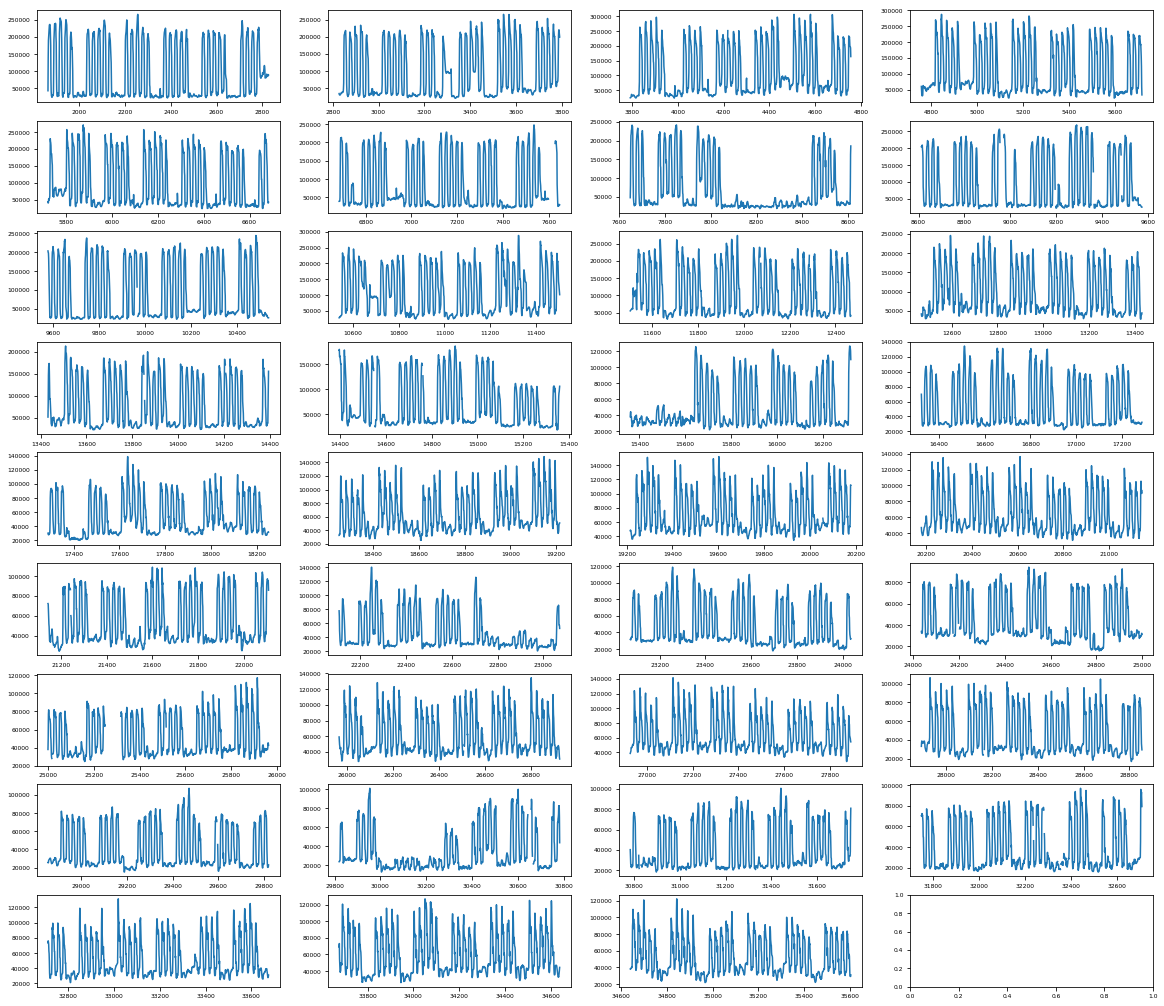

In [29]:
train.Timestamp = pd.to_datetime(train.Timestamp)
train_ = train[(train.SiteId==2)]
forecasts = train_.ForecastId.unique()
plot_num = 1
fig = plt.figure(figsize=(20,20))
for forecast_id in forecasts:    
    ts_ = train_[(train_.ForecastId==forecast_id)]
    d1, d2 = ts_.Timestamp.min(), ts_.Timestamp.max()
    fmt = subm_fmt.loc[subm_fmt.ForecastId==forecast_id]
    print("{} train: {} {} ({}, {})".format(forecast_id, d1, d2, d2-d1, len(ts_)))
    print("{} test: {} {} {}".format(forecast_id, fmt.Timestamp.min(), fmt.Timestamp.max(), len(fmt)))
    ts_.Value.plot()
    plt.rcParams.update({'font.size': 6})
    plt.subplot(10, 4, plot_num)
    plot_num += 1


[516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533
 534 535 536 537 538 539]
2014-09-23 12:15:00 2014-11-02 15:15:00
2014-11-10 16:15:00 2014-12-20 19:15:00
2014-12-28 20:15:00 2015-02-06 23:15:00
2015-02-15 00:15:00 2015-03-27 03:15:00
2015-04-04 04:15:00 2015-05-14 07:15:00
2015-05-22 08:15:00 2015-07-01 11:15:00
2015-07-09 12:15:00 2015-08-18 15:15:00
2015-08-26 16:15:00 2015-10-05 19:15:00
2015-10-13 20:15:00 2015-11-22 23:15:00
2015-12-01 00:15:00 2016-01-10 03:15:00
2016-01-18 04:15:00 2016-02-27 07:15:00
2016-03-06 08:15:00 2016-04-15 11:15:00
2016-04-23 12:15:00 2016-06-02 15:15:00
2016-06-10 16:15:00 2016-07-20 19:15:00
2016-07-28 20:15:00 2016-09-06 23:15:00
2016-09-15 00:15:00 2016-10-25 03:15:00
2016-11-02 04:15:00 2016-12-12 07:15:00
2016-12-20 08:15:00 2017-01-29 11:15:00
2017-02-06 12:15:00 2017-03-18 15:15:00
2017-03-26 16:15:00 2017-05-05 19:15:00
2017-05-13 20:15:00 2017-06-22 23:15:00
2017-07-01 00:15:00 2017-08-10 03:15:00
2017-08-18 04:15:00 2

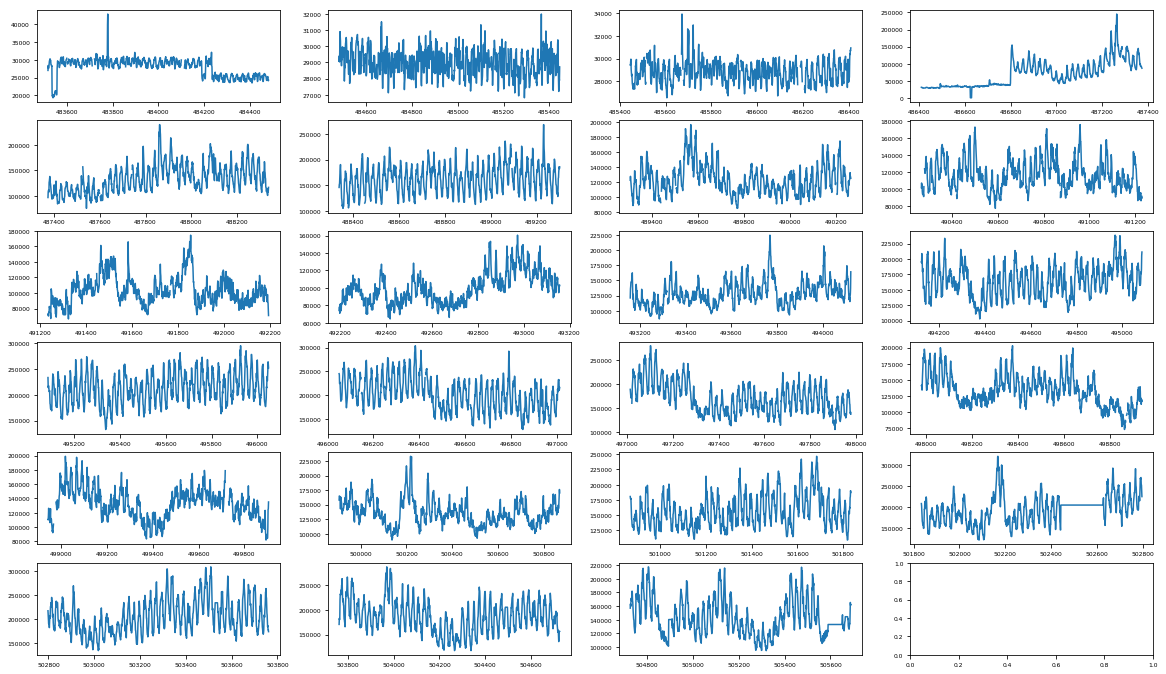

In [24]:
train_ = train[(train.SiteId==16)]
forecasts = train_.ForecastId.unique()
print(forecasts)
plot_num = 1
fig = plt.figure(figsize=(20,20))
for forecast_id in forecasts:    
    ts_ = train_[(train_.ForecastId==forecast_id)]
    print(ts_.Timestamp.min(), ts_.Timestamp.max())
    ts_.Value.plot()
    plt.rcParams.update({'font.size': 6})
    plt.subplot(10, 4, plot_num)
    plot_num += 1

In [26]:
subm_fmt = pd.read_csv('input/submission_format.csv')
subm_fmt.Timestamp = pd.to_datetime(subm_fmt.Timestamp)
subm_freq = pd.read_csv('input/submission_frequency.csv')
subm_fmt = pd.merge(subm_fmt, subm_freq, on=['ForecastId'])
subm_freq.ForecastPeriodNS.unique()/1e9

array([86400.,  3600.,   900.])